In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

In [2]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from absl import app
from absl import flags
import haiku as hk
import jax
import optax
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial

from flax.metrics import tensorboard

# Import tensorflow for dataset creation and manipulation
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds

#from jax_lensing.models.convdae import UResNet, SmallUResNet
from jax_lensing.models.normalization import SNParamsTree as CustomSNParamsTree
from jax_lensing.spectral import make_power_map
from jax_lensing.utils import load_dataset
from tqdm.notebook import tqdm

import types
from typing import Mapping, Optional, Sequence, Union

In [4]:
dataset = "kappatng"
output_dir = "../weights/gp-no_sn"
batch_size = 32
learning_rate = 1e-4
training_steps = 45000
train_split = "90%"
noise_dist_std = 0.2
spectral_norm = 0
gaussian_prior = True
gaussian_path = "../data/ktng/ktng_PS_theory.npy"
variant = "EiffL"
model_name = "SmallUResNet"
map_size = 360
resolution = 0.29

In [5]:
#import jax
#import jax.numpy as jnp
#import haiku as hk

#import types
from typing import Mapping, Optional, Sequence, Union

def check_length(length, value, name):
  if len(value) != length:
    raise ValueError(f"`{name}` must be of length 4 not {len(value)}")

class BlockV1(hk.Module):
  """ResNet V1 block with optional bottleneck."""

  def __init__(
      self,
      channels: int,
      stride: Union[int, Sequence[int]],
      use_projection: bool,
      bn_config: Mapping[str, float],
      bottleneck: bool,
      transpose: bool = False,
      name: Optional[str] = None
  ):
    super().__init__(name=name)
    self.use_projection = use_projection

    bn_config = dict(bn_config)
    bn_config.setdefault("create_scale", True)
    bn_config.setdefault("create_offset", True)
    bn_config.setdefault("decay_rate", 0.999)

    if transpose:
      maybe_transposed_conv = hk.Conv2DTranspose
    else:
      maybe_transposed_conv = hk.Conv2D

    if self.use_projection:
      self.proj_conv = maybe_transposed_conv(
          output_channels=channels,
          kernel_shape=1,
          stride=stride,
          with_bias=False,
          padding="SAME",
          name="shortcut_conv")

      self.proj_batchnorm = hk.BatchNorm(name="shortcut_batchnorm", **bn_config)

    channel_div = 4 if bottleneck else 1
    conv_0 = hk.Conv2D(
        output_channels=channels // channel_div,
        kernel_shape=1 if bottleneck else 3,
        stride=1,
        with_bias=False,
        padding="SAME",
        name="conv_0")
    bn_0 = hk.BatchNorm(name="batchnorm_0", **bn_config)

    conv_1 = maybe_transposed_conv(
        output_channels=channels // channel_div,
        kernel_shape=3,
        stride=stride,
        with_bias=False,
        padding="SAME",
        name="conv_1")

    bn_1 = hk.BatchNorm(name="batchnorm_1", **bn_config)
    layers = ((conv_0, bn_0), (conv_1, bn_1))

    if bottleneck:
      conv_2 = hk.Conv2D(
          output_channels=channels,
          kernel_shape=1,
          stride=1,
          with_bias=False,
          padding="SAME",
          name="conv_2")

      bn_2 = hk.BatchNorm(name="batchnorm_2", scale_init=jnp.zeros, **bn_config)
      layers = layers + ((conv_2, bn_2),)

    self.layers = layers

  def __call__(self, inputs, is_training, test_local_stats):
    out = shortcut = inputs

    if self.use_projection:
      shortcut = self.proj_conv(shortcut)
      shortcut = self.proj_batchnorm(shortcut, is_training, test_local_stats)

    for i, (conv_i, bn_i) in enumerate(self.layers):
      out = conv_i(out)
      out = bn_i(out, is_training, test_local_stats)
      if i < len(self.layers) - 1:  # Don't apply relu on last layer
        out = jax.nn.relu(out)

    return jax.nn.relu(out + shortcut)

class BlockGroup(hk.Module):
  """Higher level block for ResNet implementation."""

  def __init__(
      self,
      channels: int,
      num_blocks: int,
      stride: Union[int, Sequence[int]],
      bn_config: Mapping[str, float],
      bottleneck: bool,
      use_projection: bool,
      transpose: bool,
      name: Optional[str] = None,
  ):
    super().__init__(name=name)

    block_cls = BlockV1

    self.blocks = []
    for i in range(num_blocks):
      self.blocks.append(
          block_cls(channels=channels,
                    stride=(1 if i else stride),
                    use_projection=(i == 0 and use_projection),
                    bottleneck=bottleneck,
                    bn_config=bn_config,
                    transpose=transpose,
                    name="block_%d" % (i)))

  def __call__(self, inputs, is_training, test_local_stats):
    out = inputs
    for block in self.blocks:
      out = block(out, is_training, test_local_stats)
    return out


class UResNet(hk.Module):
  """ Implementation of a denoising auto-encoder based on a resnet architecture
  """

  def __init__(self,
               blocks_per_group,
               bn_config,
               bottleneck,
               channels_per_group,
               use_projection,
               name=None):
    """Constructs a Residual UNet model based on a traditional ResNet.
    Args:
      blocks_per_group: A sequence of length 4 that indicates the number of
        blocks created in each group.
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers. By default the
        ``decay_rate`` is ``0.9`` and ``eps`` is ``1e-5``.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults to
        ``False``.
      bottleneck: Whether the block should bottleneck or not. Defaults to
        ``True``.
      channels_per_group: A sequence of length 4 that indicates the number
        of channels used for each block in each group.
      use_projection: A sequence of length 4 that indicates whether each
        residual block should use projection.
      name: Name of the module.
    """
    super().__init__(name=name)
    self.resnet_v2 = False

    bn_config = dict(bn_config or {})
    bn_config.setdefault("decay_rate", 0.9)
    bn_config.setdefault("eps", 1e-5)
    bn_config.setdefault("create_scale", True)
    bn_config.setdefault("create_offset", True)

    # Number of blocks in each group for ResNet.
    check_length(4, blocks_per_group, "blocks_per_group")
    check_length(4, channels_per_group, "channels_per_group")

    self.initial_conv = hk.Conv2D(
        output_channels=32,
        kernel_shape=7,
        stride=2,
        with_bias=False,
        padding="SAME",
        name="initial_conv")

    if not self.resnet_v2:
      self.initial_batchnorm = hk.BatchNorm(name="initial_batchnorm",
                                            **bn_config)

    self.block_groups = []
    self.up_block_groups = []
    strides = (1, 2, 2, 1)
    for i in range(4):
      self.block_groups.append(
          BlockGroup(channels=channels_per_group[i],
                     num_blocks=blocks_per_group[i],
                     stride=strides[i],
                     bn_config=bn_config,
                     bottleneck=bottleneck,
                     use_projection=use_projection[i],
                     transpose=False,
                     name="block_group_%d" % (i)))

    for i in range(4):
      self.up_block_groups.append(
          BlockGroup(channels=channels_per_group[i],
                     num_blocks=blocks_per_group[i],
                     stride=strides[i],
                     bn_config=bn_config,
                     bottleneck=bottleneck,
                     use_projection=use_projection[i],
                     transpose=True,
                     name="up_block_group_%d" % (i)))

    if self.resnet_v2:
      self.final_batchnorm = hk.BatchNorm(name="final_batchnorm", **bn_config)

    self.final_upconv = hk.Conv2DTranspose(output_channels=1,
                                kernel_shape=5,
                                stride=2,
                                padding="SAME",
                                name="final_upconv")

    self.final_conv = hk.Conv2DTranspose(output_channels=1,
                                kernel_shape=5,
                                stride=2,
                                padding="SAME",
                                name="final_conv")

  def __call__(self, inputs, condition, is_training, test_local_stats=False):
    out = inputs
    out = jnp.concatenate([out, condition*jnp.ones_like(out)[...,[0]]], axis=-1)
    out = self.initial_conv(out)

    # Decreasing resolution
    levels = []
    for block_group in self.block_groups:
      levels.append(out)
      out = block_group(out, is_training, test_local_stats)

    out = jnp.concatenate([out, condition*jnp.ones_like(out)],axis=-1)

    # Increasing resolution
    for i, block_group in enumerate(self.up_block_groups[::-1]):
      out = block_group(out, is_training, test_local_stats)
      out = jnp.concatenate([out, levels[-i-1]],axis=-1)

    # Second to last upsampling, merging with input branch
    return self.final_conv(out)/(jnp.abs(condition)*jnp.ones_like(inputs)+1e-3)

class SmallUResNet(UResNet):
  """ResNet18."""

  def __init__(self,
               bn_config: Optional[Mapping[str, float]] = None,
               name: Optional[str] = None):
    """Constructs a ResNet model.
    Args:
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
        to ``False``.
      name: Name of the module.
    """
    super().__init__(blocks_per_group=(2, 2, 2, 2),
                     bn_config=bn_config,
                     bottleneck=False,
                     channels_per_group=(32, 64, 128, 128),
                     use_projection=(True, True, True, True),
                     name=name)

class MediumUResNet(UResNet):
  """ResNet18."""

  def __init__(self,
               bn_config: Optional[Mapping[str, float]] = None,
               name: Optional[str] = None):
    """Constructs a ResNet model.
    Args:
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
        to ``False``.
      name: Name of the module.
    """
    super().__init__(blocks_per_group=(2, 2, 2, 2),
                     bn_config=bn_config,
                     bottleneck=False,
                     channels_per_group=(32, 64, 128, 128),
                     use_projection=(True, True, True, True),
                     name=name)

class MediumUResNet(UResNet):
  """ResNet18."""

  def __init__(self,
               bn_config: Optional[Mapping[str, float]] = None,
               name: Optional[str] = None):
    """Constructs a ResNet model.
    Args:
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
        to ``False``.
      name: Name of the module.
    """
    super().__init__(blocks_per_group=(2, 2, 2, 2),
                     bn_config=bn_config,
                     bottleneck=False,
                     channels_per_group=(32, 64, 128, 128),
                     use_projection=(True, True, True, True),
                     name=name)

def forward(x, s, is_training=False):
    denoiser = MediumUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

#sn_fn = hk.transform_with_state(lambda x: hk.SNParamsTree(ignore_regex='[^?!.]*b$')(x))
#sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',val=2.)(x))

In [6]:
if spectral_norm > 0:
    sn_fn = hk.transform_with_state(
        lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',
                                     val=spectral_norm)(x)
    )
else:
    sn_fn = None

In [7]:
# Initialisation
optimizer = optax.chain(
  optax.adam(learning_rate=learning_rate),
  #optax.scale_by_schedule(lr_schedule)
)

rng_seq = hk.PRNGSequence(42)

if gaussian_prior:
    last_dim=2
else:
    last_dim=1

"""
params, state = model.init(next(rng_seq),
                           jnp.zeros((1, map_size, map_size, last_dim)),
                           jnp.zeros((1, 1, 1, 1)), is_training=True)
"""
params, state = model.init(next(rng_seq),
                           jnp.zeros((1, map_size, map_size, last_dim)),
                           jnp.zeros((1, 1, 1, 1)), is_training=True)

opt_state = optimizer.init(params)

In [8]:
if sn_fn is not None:
    _, sn_state = sn_fn.init(next(rng_seq), params)
else:
    sn_state = None

In [9]:
def log_gaussian_prior(map_data, sigma, ps_map):
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma[0]**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [10]:
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel
  # If the Gaussian prior is used, load the theoretical power spectrum
if gaussian_prior:
    ps_data = onp.load(gaussian_path).astype('float32')
    ell = jnp.array(ps_data[0,:])
    # massivenu: channel 4
    ps_halofit = jnp.array(ps_data[1,:] / pixel_size**2) # normalisation by pixel size
    # convert to pixel units of our simple power spectrum calculator
    kell = ell / (360/3.5/0.5) / float(map_size)
    # Interpolate the Power Spectrum in Fourier Space
    power_map = jnp.array(make_power_map(ps_halofit, map_size, kps=kell))

In [11]:
def score_fn(params, state, rng_key, batch, is_training=True):
    if gaussian_prior:
        # If requested, first compute the Gaussian prior
        gaussian_score = gaussian_prior_score(batch['y'][...,0], batch['s'][...,0], power_map)
        gaussian_score = jnp.expand_dims(gaussian_score, axis=-1)
        net_input = jnp.concatenate([batch['y'], jnp.abs(batch['s'])**2 * gaussian_score],axis=-1)
        res, state = model.apply(params, state, rng_key, net_input, batch['s'], is_training=is_training)
    else:
        res, state = model.apply(params, state, rng_key, batch['y'], batch['s'], is_training=is_training)
        gaussian_score = jnp.zeros_like(res)
    return batch, res, gaussian_score

In [12]:
"""
# Training loss
def loss_fn(params, state, rng_key, batch):
    _, res, gaussian_score = score_fn(params, state, rng_key, batch)
    loss = jnp.mean((batch['u'] + batch['s'] * (res + gaussian_score))**2)
    return loss, state
"""
@jax.jit
def loss_fn(params, state, rng_key, batch):
    #res, state = model.apply(params, state, rng_key, batch['y'], batch['s'], is_training=True)
    #loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    _, res, gaussian_score = score_fn(params, state, rng_key, batch)
    loss = jnp.mean((batch['u'] + batch['s'] * (res + gaussian_score))**2)
    
    return loss, state

In [13]:
"""
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    if spectral_norm > 0:
        new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    else:
        new_sn_state = sn_state
    return loss, new_params, state, new_sn_state, new_opt_state
"""
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    if spectral_norm > 0:
        new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    else:
        new_sn_state = sn_state
    
    return loss, new_params, state, new_sn_state, new_opt_state

In [14]:
train = load_dataset(dataset, batch_size, map_size, noise_dist_std, train_split)

In [15]:
#imshow(next(train)['y'][0,...,0]); colorbar()

In [16]:
#training_steps = 5000
losses = []

for step in tqdm(range(training_steps)):
    loss, params, state, sn_state, opt_state = update(params, state, sn_state,
                                                      next(rng_seq), opt_state,
                                                      next(train))
    losses.append(loss)
    if step%100==0:
        print(step, loss)

    if step%5000 ==0:
        with open(output_dir+'/model-%d.pckl'%step, 'wb') as file:
            pickle.dump([params, state, sn_state], file)

with open(output_dir+'/model-final.pckl', 'wb') as file:
    pickle.dump([params, state, sn_state], file)

0 0.21411258
100 0.04437286
200 0.07380173
300 0.1059969
400 0.19052413
500 0.06325517
600 0.18183805
700 0.10594884
800 0.1274908
900 0.0943908
1000 0.08106428
1100 0.09791874
1200 0.030927438
1300 0.12638876
1400 0.034686077
1500 0.13355361
1600 0.062186163
1700 0.0477651
1800 0.053702563
1900 0.09676634
2000 0.075600415
2100 0.14521891
2200 0.13894896
2300 0.13058831
2400 0.06142664
2500 0.07516256
2600 0.1204368
2700 0.092988476
2800 0.070208564
2900 0.078080244
3000 0.11228909
3100 0.17199823
3200 0.06416393
3300 0.07996673
3400 0.08500296
3500 0.059564065
3600 0.11859609
3700 0.08651276
3800 0.06479458
3900 0.108124025
4000 0.087245874
4100 0.08776159
4200 0.089130655
4300 0.07768271
4400 0.044776674
4500 0.07975623
4600 0.075805
4700 0.10520456
4800 0.09743543
4900 0.08870158
5000 0.06534702
5100 0.04443639
5200 0.08078354
5300 0.056497682
5400 0.115310416
5500 0.059340674
5600 0.12376775
5700 0.07835204
5800 0.09943964
5900 0.10984804
6000 0.10300022
6100 0.0970243
6200 0.03187

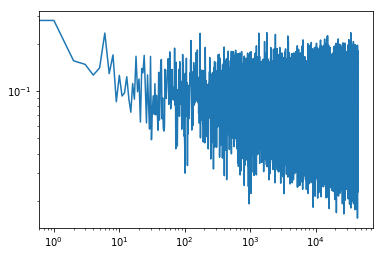

In [17]:
loglog(losses)

In [18]:
#from functools import partial
#score = partial(model.apply, params, state, next(rng_seq))

In [19]:
batch = next(train)

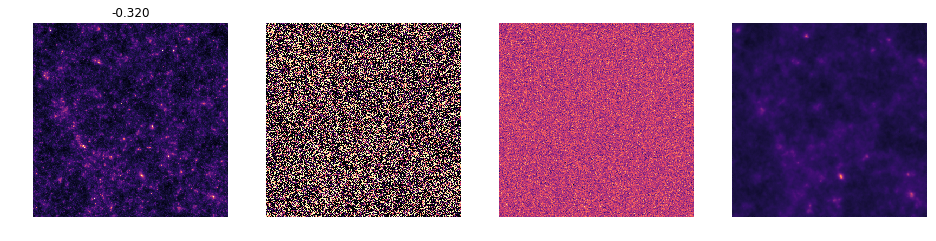

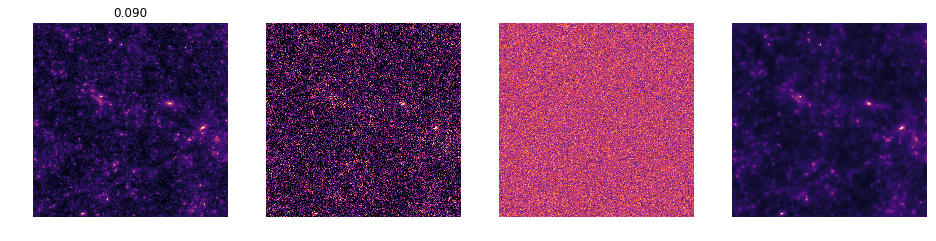

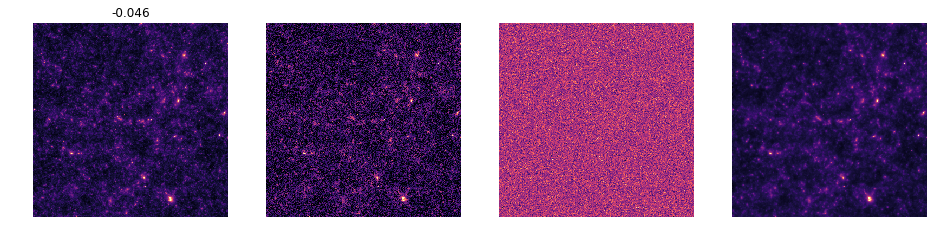

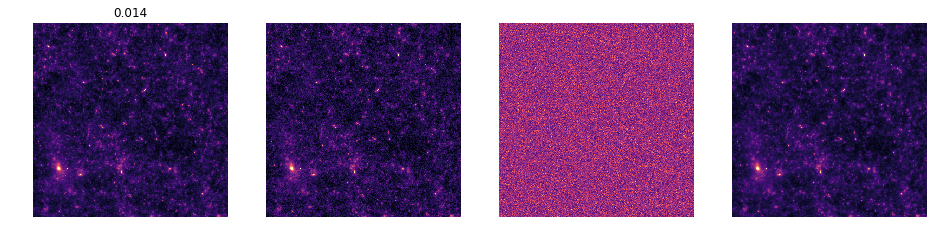

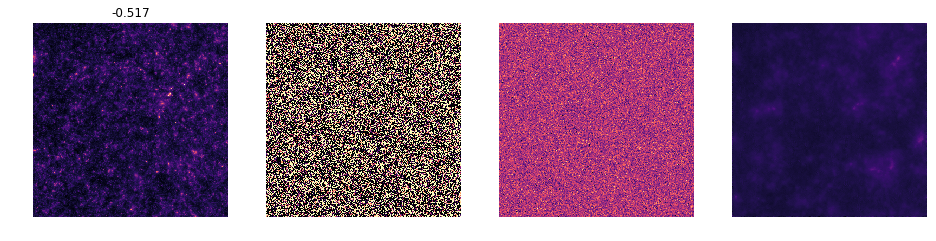

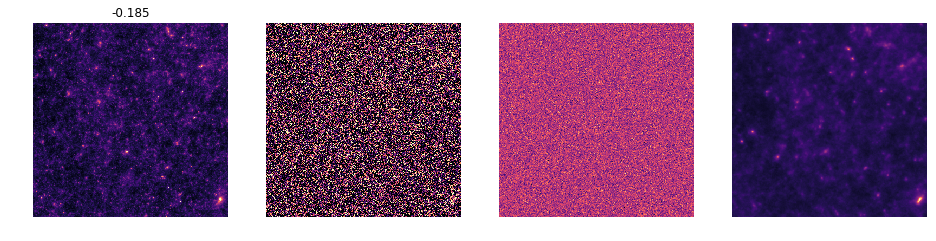

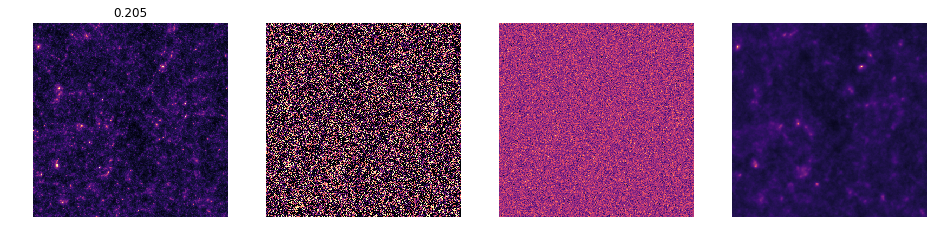

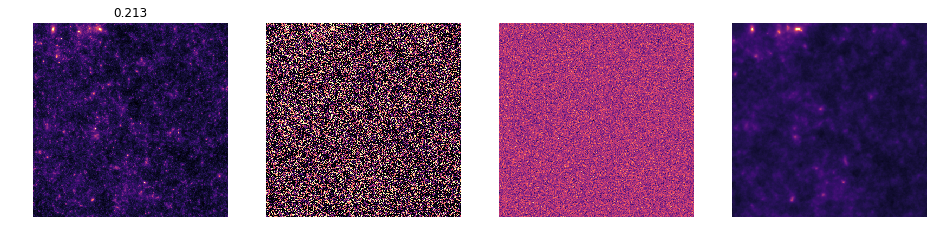

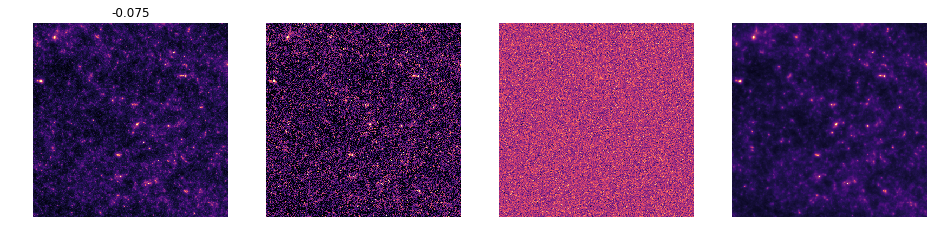

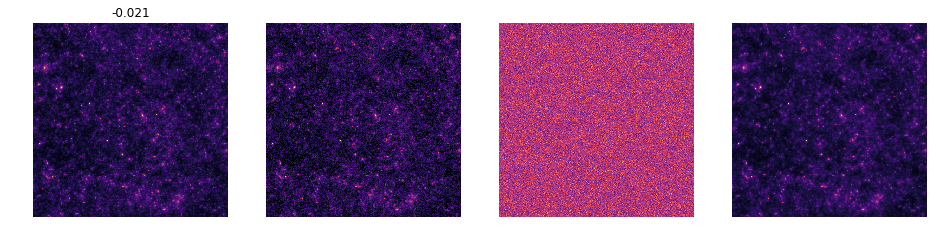

In [20]:
#res, state = score_fn(batch['x'],batch['s'], is_training=False)
_, res, gaussian_score = score_fn(params, state, next(rng_seq), batch)

for i in range(10):
    ind = i
    figure(figsize=(16,4))
    subplot(141)
    title("%0.3f"%batch['s'][ind,0,0,0])
    imshow(batch['x'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(142)
    imshow(batch['y'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(143)
    #imshow(res[ind,...,0],cmap='magma')
    imshow(res[ind,...,0] + gaussian_score[ind,...,0], cmap='magma')
    axis('off')
    #title("%0.3f"%std(batch['s'][ind,:,:,0]**2 * res[ind,...,0]))
    subplot(144)
    #imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * res[ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap='magma',vmin=-0.05,vmax=0.3)
    #batch['s'] * (res + gaussian_score))**2
    axis('off')